In [2]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_pendulum_invariance, get_SHM_invariance, get_damped_pendulum_invariance, get_damped_SHM_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_damped_pendulum_data, get_damped_SHM_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, SHM_dynamics, pendulum_dynamics, damped_SHM_dynamics, damped_pendulum_dynamics
from parameterised_invariance_kernels import get_polynomial_invariance, get_damped_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [46]:

mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 3

max_x = 150
max_v = 10
n_train = 3
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[-116.01542507   99.13618384  -33.93889212]
[-9.30769942 -5.11387399 -3.43477056]


In [65]:

moi = get_GPR_model(get_MOI(), mean, data, 500)[0]
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 5e-5
invar_density = 30
latex=""
kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)[0]
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
i = 0
for poly_f_d in [2]:
    for poly_g_d in [4]:
        kernel = get_polynomial_invariance(np.radians(150), invar_density, jitter, poly_f_d, poly_g_d) #switch
        m, fs, gs, coeff = get_GPR_model(kernel, mean, data, 3000)
        print(m.log_marginal_likelihood().numpy())

moi:232.05
known: 261.98
256.3914813550686


In [55]:
print(kernel.g_poly.transform(coeff[0][1]))
print(kernel.f_poly.transform(coeff[0][0]))

tf.Tensor(
[[ 0.0609923 ]
 [-0.87775038]
 [-0.0211619 ]
 [ 0.10254773]], shape=(4, 1), dtype=float64)
tf.Tensor(
[[ 1.74055046e-05]
 [-9.99999996e-01]], shape=(2, 1), dtype=float64)


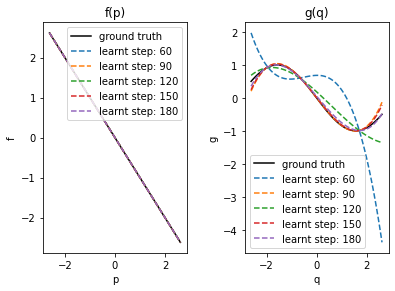

In [74]:
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='ground truth', color="black")
ax2.plot(x, -np.sin(x), color="black", label='ground truth')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax2.set_title("g(q)")
ax2.set_xlabel("q")
ax2.set_ylabel("g")
for i, (f, g) in enumerate(zip(fs, gs)):
    if i%3==0 and i>3:
        multiplier = -kernel.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(kernel.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(kernel.g_poly.transform(g)))
        ax1.plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        ax2.plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
ax1.legend()
ax2.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/pendulum_learnt_over_time.pdf")

